In [1]:
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing
from scipy import stats
import scipy.io as sio
import h5py

Load & Reorder:

In [2]:
# Load
path = "../Data/090085/Road_Data/motor_trunk_pri_sec_tert_uncl_track/patch_set.h5"

data = h5py.File(path, 'r')
X = np.array(data['image_patch'])
Y = np.array(data['road_existence'])
data.close()

In [3]:
# Reorder & Create masks
index_mask = np.arange(X.shape[0])
np.random.shuffle(index_mask)

train_mask = index_mask[:int(index_mask.size*0.75)]
test_mask = index_mask[int(index_mask.size*0.75):]

train_x = X[train_mask].flatten().reshape((train_mask.size, -1))
train_y = Y[train_mask]
train_mask = np.arange(train_x.shape[0])
np.random.shuffle(train_mask)

test_x = X[test_mask].flatten().reshape((test_mask.size, -1))
test_y = Y[test_mask]
test_mask = np.arange(test_x.shape[0])
np.random.shuffle(test_mask)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(256194, 5488) (256194,)
(85399, 5488) (85399,)


Model parameters: 

In [4]:
width = 28
height = 28
band = 7

L1_out = 1024
L2_out = 512
L3_out = 256
L4_out = 128
class_output = 1 # number of possible classifications for the problem

batch_size = 64
learning_rate = 9e-8
iteration = 5000000

Calculate Normalization Parameters:

In [5]:
# Normalize Parameters
mu = train_x.mean(axis=0, keepdims=True)
sigma = 0
for img in train_x:
    sigma += (img-mu)**2
sigma /= train_x.shape[0]

$a_i$ is the raw number (int)

$\mu = \frac 1 n \sum_{i=1}^n \frac {a_i} {\text{Max}} = \frac 1 {\text{Max}}(\frac 1 n \sum_{i=1}^n a_i)$

$\sigma = \sqrt{\frac 1 n \sum_{i=1}^n (\frac{a_i}{\text{Max}}-\mu)^2 } = \frac 1 {\text{Max}} \sqrt{\frac 1 n \sum_{i=1}^n(a_i-\mu*\text{Max})^2 } $

$\displaystyle \frac {\frac A {\text{Max}} - mu} {\sigma} = \frac {A-\mu *\text{Max}}{\sigma *\text{Max}}$

Place holders for inputs and outputs: 

In [6]:
x  = tf.placeholder(tf.float32, shape=[None, width*height*band])
y_ = tf.placeholder(tf.float32, shape=[None, class_output])

Fully Connected Layer: 

In [7]:
# Layer 1
W_fc1 = tf.Variable(tf.truncated_normal([width*height*band, L1_out], stddev=0.1))
b_fc1 = tf.Variable(tf.truncated_normal([L1_out], stddev=0.1))

fc1=tf.matmul(x, W_fc1) + b_fc1 # applying weights and biases
h_fc1 = tf.nn.relu(fc1) # ReLU activation

# Layer 2
W_fc2 = tf.Variable(tf.truncated_normal([L1_out, L2_out], stddev=0.1))
b_fc2 = tf.Variable(tf.truncated_normal([L2_out], stddev=0.1))

fc2=tf.matmul(h_fc1, W_fc2) + b_fc2# applying weights and biases
h_fc2 = tf.nn.relu(fc2) # ReLU activation

# Layer 3
W_fc3 = tf.Variable(tf.truncated_normal([L2_out, L3_out], stddev=0.1))
b_fc3 = tf.Variable(tf.truncated_normal([L3_out], stddev=0.1))

fc3=tf.matmul(h_fc2, W_fc3) + b_fc3
h_fc3 = tf.nn.relu(fc3) # ReLU activation

# Layer 4
W_fc4 = tf.Variable(tf.truncated_normal([L3_out, L4_out], stddev=0.1))
b_fc4 = tf.Variable(tf.truncated_normal([L4_out], stddev=0.1))

fc4=tf.matmul(h_fc3, W_fc4) + b_fc4
h_fc4 = tf.nn.relu(fc4) # ReLU activation

Output Layer (Softmax):

In [8]:
W_fc_out = tf.Variable(tf.truncated_normal([L4_out, class_output], stddev=0.1))
b_fc_out = tf.Variable(tf.truncated_normal([class_output], stddev=0.1))

fc_out=tf.matmul(h_fc4, W_fc_out) + b_fc_out

y_CNN= tf.nn.softmax(fc_out)

Cost function & optimizer:

In [9]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * (y_CNN), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

In [10]:
correct_prediction = tf.equal(y_CNN, y_)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Train & monitor:

(256194, 5488)
64
4003
start
step 0     : train_acc = 0.4375   , cross entropy = -0.437500 
step 1000  : train_acc = 0.359375 , cross entropy = -0.359375 
step 2000  : train_acc = 0.296875 , cross entropy = -0.296875 
step 3000  : train_acc = 0.28125  , cross entropy = -0.281250 
step 4000  : train_acc = 0.34375  , cross entropy = -0.343750 
step 5000  : train_acc = 0.34375  , cross entropy = -0.343750 
step 6000  : train_acc = 0.3125   , cross entropy = -0.312500 
step 7000  : train_acc = 0.328125 , cross entropy = -0.328125 
step 8000  : train_acc = 0.328125 , cross entropy = -0.328125 
step 9000  : train_acc = 0.421875 , cross entropy = -0.421875 
step 10000 : train_acc = 0.34375  , cross entropy = -0.343750 
step 11000 : train_acc = 0.25     , cross entropy = -0.250000 
step 12000 : train_acc = 0.328125 , cross entropy = -0.328125 
step 13000 : train_acc = 0.4375   , cross entropy = -0.437500 
step 14000 : train_acc = 0.40625  , cross entropy = -0.406250 
step 15000 : train_acc = 0

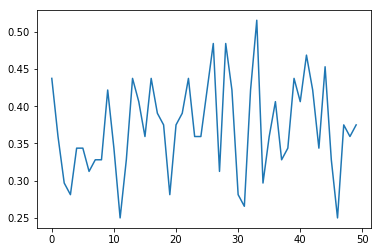

In [11]:
batch_num = int(train_mask.size/batch_size)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

print("start")
learning_curve = []
for i in range(iteration):
    start = i%batch_num * batch_size
    end = start + batch_size

    if end > train_mask.size:
        end = train_mask.size
        np.random.shuffle(train_mask)
    
    train_index = train_mask[start:end]    
    batch = [((train_x[train_index]-mu)/sigma), np.matrix(train_y[train_index]).T]

    if i%1000 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1]})

        learning_curve.append(train_accuracy)
        print("step %-6d: train_acc = %-9g, cross entropy = %-10f"
              %(i, train_accuracy, cross_entropy.eval(feed_dict={x:batch[0], y_: batch[1]})))
        
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})
print("finish")

plt.plot(learning_curve)
plt.show()

Evaluate:

In [20]:
train_acc = []
for i in range(batch_num+1):
    start = i%batch_num * batch_size
    end = start + batch_size

    if end > train_mask.size:
        end = train_mask.size
    
    batch = [((train_x[start:end]-mu)/sigma), np.matrix(train_y[start:end]).T]

    train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1]})
    train_acc.append(train_accuracy * (end-start))
    
print("train_acc = ", sum(train_acc)/train_mask.size)

train_acc =  0.368474671538


In [21]:
test_acc = []
batch_num = int(test_mask.size/batch_size)
for i in range(batch_num+1):
    start = i%batch_num * batch_size
    end = start + batch_size

    if end > test_mask.size:
        end = test_mask.size
    
    batch = [((test_x[start:end]-mu)/sigma), np.matrix(test_y[start:end]).T]

    test_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1]})
    test_acc.append(test_accuracy * (end-start))
    
print("test_acc = ", sum(test_acc)/test_mask.size)

test_acc =  0.367615545849


In [ ]:
sess.close() #finish the session